### Задание ###

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### Импорт библиотек, чтение данных, задание стандартных параметров графиков

In [1]:
# Импорт библиотек
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
import requests
from urllib.parse import urlencode

In [2]:
# Подготовка ссылок для скачивания данных
customers_df_download_link = 'https://disk.yandex.ru/d/FUi5uSd6BfG_ig'
orders_data_df_download_link = 'https://disk.yandex.ru/d/t9Li4JOfgxuUrg'
orders_item_df_download_link = 'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw'

In [3]:
# Чтение данных
def download_link(public_key):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url


customers_df = pd.read_csv(download_link(customers_df_download_link))
orders_data_df = pd.read_csv(download_link(orders_data_df_download_link))
orders_item_df = pd.read_csv(download_link(orders_item_df_download_link))

In [4]:
# Стандартные параметра для графиков
sns.set_theme(style='whitegrid', palette='deep', font_scale=2)

### Что считать продажей? ###

В данном случае продаже будет считать подтверждение оплаты и статус не "canceled".
Данные критерии были выбраны, так как есть факт оплаты, и при этом товар либо доставлен, либо доставляется.
<br> При этом статус заказа "unavailable" может означать только временную недоступность товара.

In [5]:
orders_approved = orders_data_df[orders_data_df.order_approved_at.notnull()]
orders_not_canceled = orders_data_df.query("order_status != 'canceled'")

In [6]:
# Создание df с подтверждёнными покупками
confirmed_purchases_df = orders_approved[['customer_id']].merge(orders_not_canceled, on='customer_id')

### Сколько у нас пользователей, которые совершили покупку только один раз? ###

In [7]:
print('Совершили покупку один раз: ')
customers_df[['customer_id', 'customer_unique_id']].merge(confirmed_purchases_df, on='customer_id') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'n_of_purchases'}) \
    .query('n_of_purchases == 1') \
    .shape[0]

Совершили покупку один раз: 


92621

### Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? ###

Не совсем ясно, что считать "недоставленным товаром". Предположу, что подразумевается товар со статусом != delivered.

In [8]:
# Создание столбца с датой в виде "год-месяц"
orders_data_df.order_approved_at = pd.to_datetime(orders_data_df.order_approved_at)
orders_data_df['order_approved_at_year_and_month'] = orders_data_df['order_approved_at'].dt.strftime('%Y-%m') 

In [9]:
not_delivered_by_year_and_month = orders_data_df \
    .query("order_status != 'delivered'")[['order_id', 'order_status', 'order_approved_at_year_and_month']]

In [10]:
not_delivered_by_year_and_month_mean = not_delivered_by_year_and_month\
    .groupby('order_approved_at_year_and_month', as_index=False)\
    .agg({'order_id': 'count'})

In [11]:
not_delivered_by_year_and_month_grouped = not_delivered_by_year_and_month\
    .groupby(['order_approved_at_year_and_month', 'order_status'], as_index=False)\
    .agg({'order_id': 'count'})

In [12]:
print('В среднем ежемесячно не доставляются товары, шт.:')
round(not_delivered_by_year_and_month_mean.order_id.mean())

В среднем ежемесячно не доставляются товары, шт.:


128

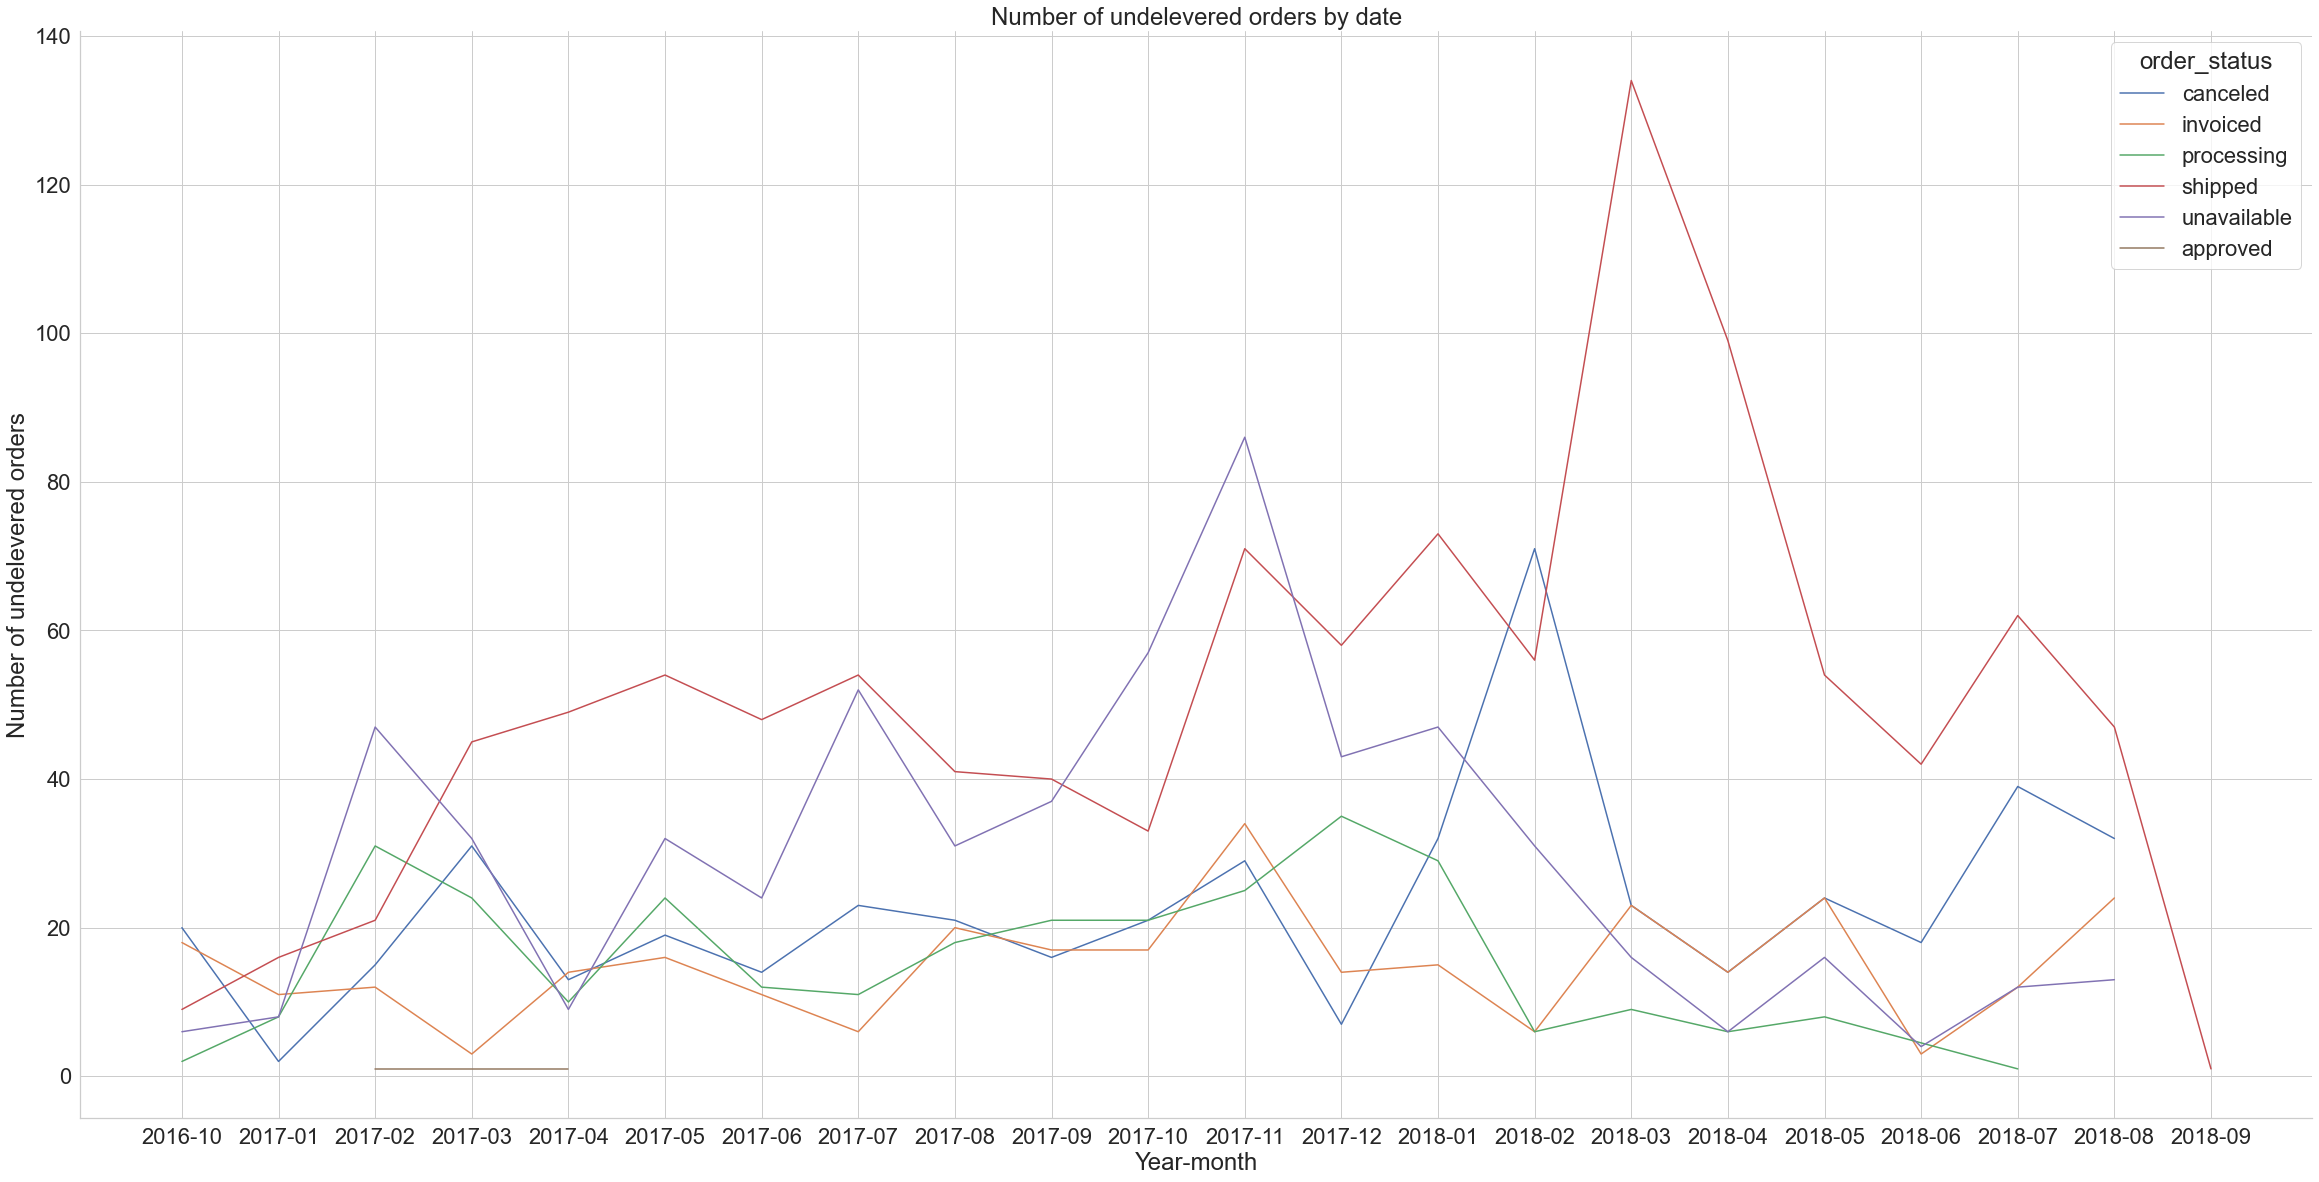

In [13]:
plt.figure(figsize=(40, 20))
plt.xlabel('Year-month')
plt.ylabel('Number of undelevered orders')
plt.title('Number of undelevered orders by date')

sns.lineplot(x='order_approved_at_year_and_month', y='order_id',
             data=not_delivered_by_year_and_month_grouped, hue='order_status')
sns.despine()

In [14]:
not_delivered_by_year_and_month_grouped

,order_approved_at_year_and_month,order_status,order_id
0,2016-10,canceled,20
1,2016-10,invoiced,18
2,2016-10,processing,2
3,2016-10,shipped,9
4,2016-10,unavailable,6
...,...,...,...
101,2018-08,canceled,32
102,2018-08,invoiced,24
103,2018-08,shipped,47
104,2018-08,unavailable,13


###  По каждому товару определить, в какой день недели товар чаще всего покупается ###

Считаем, что дата покупки = order_purchase_timestamp

In [15]:
# Merge df'ов для получения product_id
order_item_data_df = orders_data_df[['order_id', 'order_approved_at']]\
    .merge(orders_item_df[['order_id', 'product_id']], on='order_id')

In [16]:
order_item_data_df['order_approved_at_dayname'] = order_item_data_df.order_approved_at.dt.day_name()

In [17]:
order_item_data_df.groupby(['product_id', 'order_approved_at_dayname'], as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'n_of_boughts'})\
    .groupby(['product_id', 'order_approved_at_dayname'], as_index=False)\
    .agg({'n_of_boughts': 'max'})\
    .sort_values('n_of_boughts', ascending=False)

,product_id,order_approved_at_dayname,n_of_boughts
41082,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20152,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
41077,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,96
15933,422879e10f46682990de24d770e7f83d,Tuesday,89
41083,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,89
...,...,...,...
23986,63ee501f72520d5ec54cef5fd3a21a20,Wednesday,1
23988,63f4d40c05db6ade462cecef857eec34,Monday,1
23990,63f4d40c05db6ade462cecef857eec34,Wednesday,1
23991,63f52009dc3ddb733394e80183aed0f0,Saturday,1


### Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. ###

In [18]:
mean_boughts_by_week_df = customers_df[['customer_id', 'customer_unique_id']]\
    .merge(confirmed_purchases_df, on='customer_id')[['customer_unique_id', 'order_id', 'order_purchase_timestamp']]

In [19]:
mean_boughts_by_week_df['order_purchase_timestamp'] = pd.\
    to_datetime(mean_boughts_by_week_df['order_purchase_timestamp'])

In [20]:
mean_boughts_by_week_df['order_purchase_year'] = mean_boughts_by_week_df.order_purchase_timestamp.dt.year
mean_boughts_by_week_df['order_purchase_month'] = mean_boughts_by_week_df.order_purchase_timestamp.dt.month_name()

In [21]:
# Функция расчёта номера недели месяца
def add_week_of_month(df):

    df['order_purchase_week'] = pd.to_numeric(df.order_purchase_timestamp.dt.day / 7)
    df['order_purchase_week'] = df['order_purchase_week'].apply(lambda x: math.ceil(x))
    return df

In [22]:
mean_boughts_by_week_df = add_week_of_month(mean_boughts_by_week_df)

In [23]:
mean_boughts_by_week_df.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_week
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017,May,3
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018,January,2
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018,May,3
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018,March,2
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018,July,5


In [24]:
gr_list = ['customer_unique_id', 'order_purchase_year', 'order_purchase_month', 'order_purchase_week']

mean_boughts_by_week_df = mean_boughts_by_week_df\
    .groupby(gr_list, as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'n_of_boughts'})\
    .sort_values(['order_purchase_year', 'order_purchase_month', 'order_purchase_week'])

In [25]:
mean_boughts_by_week_df

,customer_unique_id,order_purchase_year,order_purchase_month,order_purchase_week,n_of_boughts
94636,f7b981e8a280e455ac3cbe0d5d171bd1,2016,December,4,1
74,0032c76b20340da25249092a268ce66c,2016,October,1,1
2561,06bdfbbe1857c3c925ec81abfb1c9666,2016,October,1,1
3002,07d5b1f9bdd053347f0213187b343ac9,2016,October,1,1
3148,0829f7df6577d5a4b65439bea701405f,2016,October,1,1
...,...,...,...,...,...
96751,fd6e77c2cf473f2f20e58c6e917ecacb,2018,May,5,1
96870,fdbe9abd8e36c2606144570edc51b24f,2018,May,5,1
96953,fde9624e2eb42ae1a340a6e5c836a179,2018,May,5,1
97674,ffd402998b20b0b8325f54e770264733,2018,May,5,1


### Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. ###

In [26]:
# Перевод столбцов с временем в datetime

confirmed_purchases_df.order_approved_at = pd.to_datetime(confirmed_purchases_df.order_approved_at)
confirmed_purchases_df.order_purchase_timestamp = pd.to_datetime(confirmed_purchases_df.order_purchase_timestamp)

In [27]:
# Создание df для анализа

col_list = ['customer_unique_id', 'customer_id', 'order_id', 'order_purchase_timestamp']
df_to_analyze = confirmed_purchases_df[['customer_id', 'order_id', 'order_purchase_timestamp']]\
    .merge(customers_df[['customer_id', 'customer_unique_id']])[col_list]

In [28]:
df_to_analyze.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33
1,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37
2,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49
3,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06
4,72632f0f9dd73dfee390c9b22eb56dd6,8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39


In [29]:
# Создание когорт

df1 = df_to_analyze.groupby('customer_unique_id', as_index=False)\
    .agg({'order_purchase_timestamp': 'min'})\
    .rename(columns={'order_purchase_timestamp_y': 'group'})\
    .sort_values('order_purchase_timestamp')

df_to_analyze = df_to_analyze.merge(df1, on='customer_unique_id', how='outer')    

In [30]:
df_to_analyze.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp_x,order_purchase_timestamp_y
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38
1,7c396fd4830fd04220f754e42b4e5bff,31f31efcb333fcbad2b1371c8cf0fa84,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,2017-09-04 11:26:38
2,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-24 20:41:37
3,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:38:49
4,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:28:06


In [31]:
df_to_analyze['period'] = df_to_analyze['order_purchase_timestamp_x'].dt.to_period('M')
df_to_analyze['group'] = df_to_analyze['order_purchase_timestamp_y'].dt.to_period('M')

In [32]:
df_to_analyze.head()

,customer_unique_id,customer_id,order_id,order_purchase_timestamp_x,order_purchase_timestamp_y,period,group
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-09-04 11:26:38,2017-10,2017-09
1,7c396fd4830fd04220f754e42b4e5bff,31f31efcb333fcbad2b1371c8cf0fa84,69923a4e07ce446644394df37a710286,2017-09-04 11:26:38,2017-09-04 11:26:38,2017-09,2017-09
2,af07308b275d755c9edb36a90c618231,b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-24 20:41:37,2018-07,2018-07
3,3a653a41f6f9fc3d2a113cf8398680e8,41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:38:49,2018-08,2018-08
4,7c142cf63193a1473d2e66489a9ae977,f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:28:06,2017-11,2017-11


In [33]:
another_col_list = ['customer_id', 'order_id', 'order_purchase_timestamp_x', 'order_purchase_timestamp_y']
df_to_analyze.drop(another_col_list, axis=1, inplace=True)

In [34]:
al_dente_df = df_to_analyze.groupby(['group', 'period'], as_index=False)\
    .agg({'customer_unique_id': 'count'})

In [35]:
# Кол-во клиентов в нулевой день

zero_month_df = al_dente_df.query('period == group')[['group', 'customer_unique_id']]

In [36]:
d_rename = {'customer_unique_id_x': 'customer_unique_id_period', 'customer_unique_id_y': 'customer_unique_id_group'}

almost_ready_df = al_dente_df\
    .merge(zero_month_df, on='group', how='outer')\
    .rename(columns=d_rename)

In [37]:
# Вычисление RR

a = almost_ready_df.customer_unique_id_period / almost_ready_df.customer_unique_id_group
almost_ready_df['rr'] = round((a) * 100, 2)

In [38]:
cohort_rr_df = almost_ready_df.pivot_table(index='group', columns='period', values='rr')\
    .fillna(0)

In [39]:
cohort_rr_df

period,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
group,,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2016-10,0.0,100.0,0.0,0.0,0.00,0.00,0.33,0.00,0.00,0.33,...,0.00,0.33,0.00,0.33,0.00,0.67,0.67,0.00,0.00,0.00
2016-12,0.0,0.0,100.0,100.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2017-01,0.0,0.0,0.0,100.0,0.38,0.25,0.13,0.38,0.13,0.50,...,0.13,0.76,0.38,0.13,0.13,0.25,0.38,0.00,0.13,0.00
2017-02,0.0,0.0,0.0,0.0,100.00,0.23,0.29,0.11,0.40,0.11,...,0.11,0.29,0.17,0.17,0.11,0.06,0.06,0.29,0.00,0.00
2017-03,0.0,0.0,0.0,0.0,0.00,100.00,0.53,0.34,0.45,0.34,...,0.08,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15,0.00
2017-04,0.0,0.0,0.0,0.0,0.00,0.00,100.00,0.63,0.25,0.21,...,0.30,0.17,0.25,0.08,0.08,0.04,0.08,0.08,0.21,0.00
2017-05,0.0,0.0,0.0,0.0,0.00,0.00,0.00,100.00,0.49,0.58,...,0.16,0.25,0.33,0.25,0.33,0.27,0.03,0.22,0.27,0.00
2017-06,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,100.00,0.44,...,0.35,0.22,0.13,0.22,0.31,0.31,0.16,0.13,0.22,0.00


<AxesSubplot:xlabel='period', ylabel='group'>

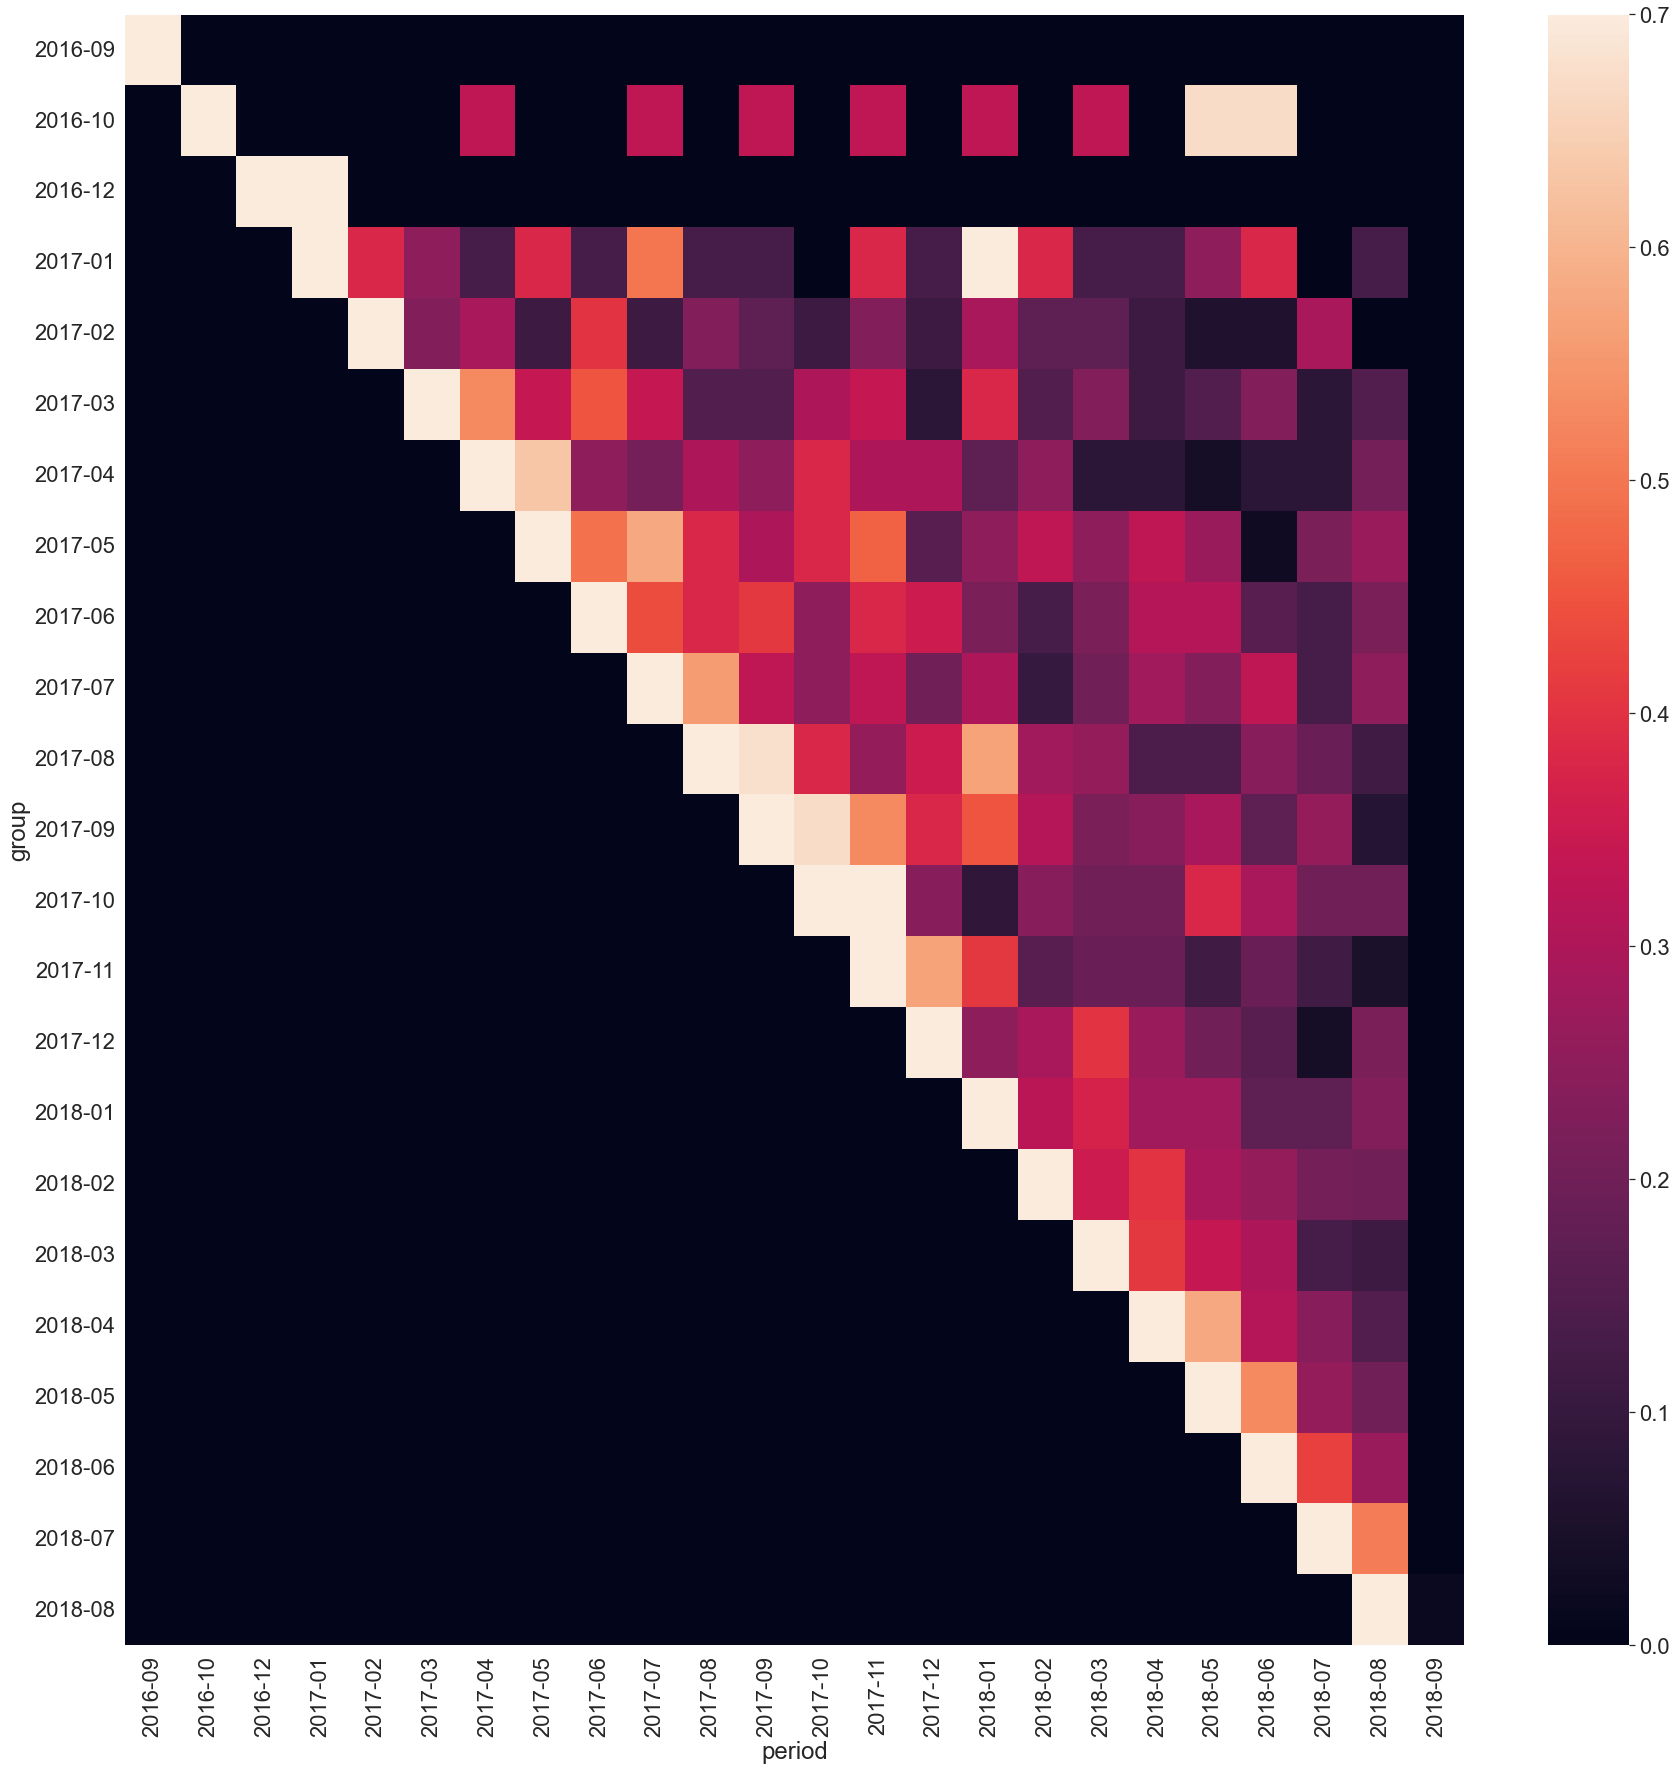

In [40]:
plt.figure(figsize=(30, 30))
sns.heatmap(cohort_rr_df, vmax=0.7)

Когорта с наибольшим RR на 3-й месяц - это когорта 2017-03

### Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [41]:
df_to_analyze_rfm = confirmed_purchases_df[['customer_id', 'order_id', 'order_purchase_timestamp']]\
    .merge(customers_df[['customer_id', 'customer_unique_id']])

In [42]:
# Merge для построения Monetory

merged_df_to_analyze_rfm = df_to_analyze_rfm.merge(orders_item_df[['order_id', 'price']], on='order_id')

In [43]:
merged_df_to_analyze_rfm['order_purchase_timestamp'] = merged_df_to_analyze_rfm['order_purchase_timestamp']\
    .dt.strftime('%Y-%m-%d')

In [44]:
merged_df_to_analyze_rfm['date_diff'] = pd.to_datetime(dt.datetime.today().strftime('%Y-%m-%d')) - pd\
    .to_datetime(merged_df_to_analyze_rfm['order_purchase_timestamp'])

In [45]:
customer_price_df = merged_df_to_analyze_rfm.groupby('customer_unique_id', as_index=False)\
    .agg({'price': 'sum'})\
    .rename(columns={'price': 'monetary'})

In [46]:
customer_frequency_df = merged_df_to_analyze_rfm.groupby('customer_unique_id', as_index=False)\
    .agg({'order_id': 'count'})\
    .rename(columns={'order_id': 'frequency'})

In [47]:
customer_recency_df = merged_df_to_analyze_rfm.groupby('customer_unique_id', as_index=False)\
    .agg({'date_diff': 'mean'})\
    .rename(columns={'date_diff': 'recency'})

In [48]:
rfm_df = customer_price_df.merge(customer_frequency_df)\
    .merge(customer_recency_df)

In [49]:
# Построение границ групп

r_q_66 = rfm_df.recency.quantile(0.66)
r_q_33 = rfm_df.recency.quantile(0.33)

f_q_66 = rfm_df.frequency.quantile(0.66)
f_q_33 = rfm_df.frequency.quantile(0.33)

m_q_66 = rfm_df.monetary.quantile(0.66)
m_q_33 = rfm_df.monetary.quantile(0.33)

In [50]:
print('R:')
print(f'33-й процентиль равен: {r_q_33}')
print(f'66-й процентиль равен: {r_q_66}')
print('F:')
print(f'33-й процентиль равен: {f_q_33}')
print(f'66-й процентиль равен: {f_q_66}')
print('M:')
print(f'33-й процентиль равен: {m_q_33}')
print(f'66-й процентиль равен: {m_q_66}')

R:
33-й процентиль равен: 1556 days 00:00:00
66-й процентиль равен: 1695 days 00:00:00
F:
33-й процентиль равен: 1.0
66-й процентиль равен: 1.0
M:
33-й процентиль равен: 57.99
66-й процентиль равен: 124.99


In [51]:
def rfm_category(df_column, divide_1=0, divide_2=0):

    l_ = []

    if rfm_df.recency.dtype == '<m8[ns]':

        for i in df_column:

            if i > divide_2:
                l_.append(1)
            elif divide_1 < i <= divide_2:
                l_.append(2)
            else:
                l_.append(3)
    
    else:

        for i in df_column:
            
            if i > divide_2:
                l_.append(3)
            elif divide_1 < i <= divide_2:
                l_.append(2)
            else:
                l_.append(1)

    return l_

In [52]:
rfm_df['R'] = rfm_category(rfm_df.recency, r_q_33, r_q_66)
rfm_df['F'] = rfm_category(rfm_df.frequency, f_q_33, f_q_66)
rfm_df['M'] = rfm_category(rfm_df.monetary, m_q_33, m_q_66)

In [53]:
rfm_df['RFM'] = rfm_df['R'].astype(str) + rfm_df['F'].astype(str) + rfm_df['M'].astype(str)

In [54]:
rfm_df

,customer_unique_id,monetary,frequency,recency,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,1518 days,3,3,1,331
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,1521 days,3,3,3,333
2,0000f46a3911fa3c0805444483337064,69.00,1,1944 days,1,3,2,132
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,1728 days,1,3,3,133
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,1695 days,2,3,1,231
...,...,...,...,...,...,...,...,...
94971,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,2,1854 days,1,1,1,111
94972,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,1669 days,2,3,2,232
94973,ffff371b4d645b6ecea244b27531430a,89.90,1,1975 days,1,3,2,132
94974,ffff5962728ec6157033ef9805bacc48,115.00,1,1526 days,3,3,2,332


In [55]:
rfm_df.groupby('RFM', as_index=False)\
      .agg({'customer_unique_id': 'count'})

,RFM,customer_unique_id
0,111,2289
1,112,1338
2,113,579
3,131,8611
4,132,9521
5,133,9950
6,211,2357
7,212,1198
8,213,460
9,231,8399
